### Identifying topics in recent top news articles

This notebook uses LDA modeling to identify topics in recent top news articles.  
The articles are gathered via API calls through newsapi.org and selected by popularity from each provider.  
  
The notebook is intended as a generic solution to gathering and topic modeling news. The period and category for the articles can be changed. Given the dynamic nature, the best model and analysis of the results will be in a different notebook. This also means that there is no guarantee of interpretability in the resulting topics, as these will most likely require tuning depending on the specific subset of news articles.

In [2]:
import pandas as pd
import numpy as np
import requests
import json
import re
from tqdm.notebook import tqdm_notebook
from newsapi import NewsApiClient

import nltk
import spacy
import gensim
from gensim import models
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud

In [3]:
pd.set_option('max_colwidth', 600)

### Getting news data via API call

Getting news articles via API call through newsapi.  
Ideally I would like more data, but the API calls are (understandably) restricted in the free version.  

In [ ]:
# API KEY - remember to remove!
newsapi = NewsApiClient(api_key='xxxxxxxxxxxxxxxxxxxxxxxxx')

In [ ]:
# API call parameters
from_date = '2022-02-12'
to_date = '2022-02-26'

In [ ]:
# Getting a list of sources in general news
def get_sources_general():
    sources_list = newsapi.get_sources(language='en',country='us',category='general')
    sources_df = pd.json_normalize(sources_list,record_path=['sources'])
    sources_df.to_csv('sources.csv',index=False)
    return sources_df

In [ ]:
# Getting a list of sources in technology news
def get_sources_tech():
    sources_list = newsapi.get_sources(language='en',country='us',category='technology')
    sources_df = pd.json_normalize(sources_list,record_path=['sources'])
    sources_df.to_csv('sources.csv',index=False)
    return sources_df

In [ ]:
# Getting news
def get_news():
    news_dict = {}
    for s in list(sources_df['id']):
        print('Getting news from',s)
        response = newsapi.get_everything(sources=s,
                                          #page=1,
                                          from_param=from_date,
                                          to=to_date,
                                          language='en',
                                          sort_by='popularity')
        flatten = pd.json_normalize(response,record_path=['articles'])
        news_dict[s] = flatten
    news_df = pd.concat([news_dict[s] for s in list(sources_df['id'])],ignore_index=True)
    news_df.to_csv('news.csv',index=False)
    return news_df

In [ ]:
# Get news
sources_df = get_sources_tech()
news_df = get_news()

### Loading data

In [79]:
# Get data
news_df = pd.read_csv('news.csv')
sources_df = pd.read_csv('sources.csv')

In [81]:
# Optionally select sources
#select_sources = ['techradar','engadget','wired']
#news_df = news_df[news_df['source.id'].isin(select_sources)]
#news_df.reset_index()

In [82]:
news_df['publishedAtDt'] = pd.to_datetime(news_df['publishedAt'])

In [84]:
news_df.head()

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name,publishedAtDt
0,Sam Machkovech,Cyberpunk 2077’s new five-hour trial arrives alongside next-gen patch,"Hands-on: loading times, what ""ray tracing"" means on console, PC changes.",https://arstechnica.com/gaming/2022/02/cyberpunk-2077s-new-five-hour-trial-arrives-alongside-next-gen-patch/,https://cdn.arstechnica.net/wp-content/uploads/2022/02/cyber-keanu-lounge-760x380.jpg,2022-02-15T22:13:08Z,Enlarge/ Virtual Keanu Reeves rests on his laurels after the latest Cyberpunk 2077 patch. But should he get up and do more before relaxing? We look into it.\r\n10 with 10 posters participating\r\nA surpr… [+5368 chars],ars-technica,Ars Technica,2022-02-15 22:13:08+00:00
1,Scharon Harding,"Google turns old Macs, PCs into Chromebooks with Chrome OS Flex","Google acquisition results in free, downloadable Chrome OS.",https://arstechnica.com/gadgets/2022/02/google-turns-old-macs-pcs-into-chromebooks-with-chrome-os-flex/,https://cdn.arstechnica.net/wp-content/uploads/2022/02/UPDATED-UI-SCREENS-01.png,2022-02-15T17:00:17Z,"Enlarge/ Google Chrome OS Flex. \r\n0 with 0 posters participating\r\nWhether you have an aging Windows PC in the classroom or a dated Mac in your home office that can't handle macOS 12 Monterey, Google … [+2420 chars]",ars-technica,Ars Technica,2022-02-15 17:00:17+00:00
2,Jeff Dunn,Sony’s latest wireless earbuds have donut holes in them (on purpose),"Hands-on: Oddly designed LinkBuds are built around ambient sound, launch today for $180.",https://arstechnica.com/gadgets/2022/02/sony-linkbuds-announced-price-features/,https://cdn.arstechnica.net/wp-content/uploads/2022/02/Sony-LinkBuds-hero-760x380.jpg,2022-02-15T17:00:48Z,"Enlarge/ Sony's latest true wireless earbuds, the LinkBuds. Their drivers are shaped like rings in order to allow ambient sound in naturally, the idea being to let you stay persistently aware of your… [+4536 chars]",ars-technica,Ars Technica,2022-02-15 17:00:48+00:00
3,Scharon Harding,"DIY handheld PC uses mechanical keyboard, Game Boy pieces, Raspberry Pi",Small number of electronic parts and a healthy amount of 3D printing.,https://arstechnica.com/gadgets/2022/02/diy-handheld-pc-uses-mechanical-keyboard-game-boy-pieces-raspberry-pi/,https://cdn.arstechnica.net/wp-content/uploads/2022/02/penkesu.computer-4-760x380.jpg,2022-02-15T17:03:04Z,"1 with 1 posters participating\r\nIf someone is using a handheld PC these days, it's almost certainly a smartphone. But a Raspberry Pi has a way of bringing out an enthusiast's retro side. Add in some … [+1431 chars]",ars-technica,Ars Technica,2022-02-15 17:03:04+00:00
4,Andrew Cunningham,Microsoft will tweak Windows 11’s UI and features pretty much whenever it wants,"""Continuous innovation"" will be delivered via a ""variety of update mechanisms.""",https://arstechnica.com/gadgets/2022/02/microsoft-will-tweak-windows-11s-ui-and-features-pretty-much-whenever-it-wants/,https://cdn.arstechnica.net/wp-content/uploads/2021/12/win11-start.png,2022-02-15T17:00:39Z,"0 with 0 posters participating\r\nMicrosoft announced that Windows 11 would be getting a few updates of note this month, and today, those updates are available for most Windows 11 PCs to install. The f… [+2280 chars]",ars-technica,Ars Technica,2022-02-15 17:00:39+00:00


In [85]:
sources_df.head()

,id,name,description,url,category,language,country
0,ars-technica,Ars Technica,"The PC enthusiast's resource. Power users and the tools they love, without computing religion.",http://arstechnica.com,technology,en,us
1,crypto-coins-news,Crypto Coins News,"Providing breaking cryptocurrency news - focusing on Bitcoin, Ethereum, ICOs, blockchain technology, and smart contracts.",https://www.ccn.com,technology,en,us
2,engadget,Engadget,Engadget is a web magazine with obsessive daily coverage of everything new in gadgets and consumer electronics.,https://www.engadget.com,technology,en,us
3,hacker-news,Hacker News,"Hacker News is a social news website focusing on computer science and entrepreneurship. It is run by Paul Graham's investment fund and startup incubator, Y Combinator. In general, content that can be submitted is defined as ""anything that gratifies one's intellectual curiosity"".",https://news.ycombinator.com,technology,en,us
4,recode,Recode,"Get the latest independent tech news, reviews and analysis from Recode with the most informed and respected journalists in technology and media.",http://www.recode.net,technology,en,us


To get as much information as possible and given the slightly different ways of using the description field on the sources, I concatenate the title and description to use in the analysis.

In [86]:
news_df['title_desc'] = news_df['title']+' '+news_df['description']

In [87]:
# Analysis field (only using unigrams)
field = 'title_desc'
#field = 'title'

### Preprocessing

This step performs various preprocessing techniques with one primary goal - create input for the topic model with as many "meaningful" words as possible:  
- Basic text cleaning.  
- Removal of stopwords.  
- Removal of short words.  
- POS-tagging for better lemmatization and possibly filtering to give the LDA model more meaning.  
- Lemmatization and stemming (stemming should in theory be unnecessary, but I do it just to be sure).

In [88]:
# Creating list of stopwords
spacy_stopwords = spacy.load('en_core_web_sm').Defaults.stop_words
nltk_stopwords = nltk.corpus.stopwords.words('english')
stopwords_list = []
stopwords_list.extend(spacy_stopwords)
stopwords_list.extend(nltk_stopwords)

In [89]:
# Identifying the POS-tag as input for lemmatization for better result
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

**POS-tags**

| Tag  | Meaning             | Examples                               |
|------|---------------------|----------------------------------------|
| ADJ  | adjective           | new, good, high, special, big, local   |
| ADP  | adposition          | on, of, at, with, by, into, under      |
| ADV  | adverb              | really, already, still, early, now     |
| CONJ | conjunction         | and, or, but, if, while, although      |
| DET  | determiner, article | the, a, some, most, every, no, which   |
| NOUN | noun                | year, home, costs, time, Africa        |
| NUM  | numeral             | twenty-four, fourth, 1991, 14:24       |
| PRT  | particle            | at, on, out, over per, that, up, with  |
| PRON | pronoun             | he, their, her, its, my, I, us         |
| VERB | verb                | is, say, told, given, playing, would   |
| .    | punctuation marks   | . , ; !                                |
| X    | other               | ersatz, esprit, dunno, gr8, univeristy |

In [90]:
# Allowed POS-tags
#allowed_pos = ['n','v','r]
allowed_pos = ['n','v']

In [91]:
# Preprocessing
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    # Lowercase
    sentence = sentence.lower()
    
    # Removing special characters and numbers
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_char = re.sub('[^A-Za-z ]+', '', rem_url)
    rem_num = re.sub('[0-9]+', '', rem_char)
    
    # Tokenization
    tokens = tokenizer.tokenize(rem_num) 
    
    # Remove stopwords and short words
    filtered_words = [w for w in tokens if len(w) > 3 if not w in stopwords_list if get_wordnet_pos(w) in (allowed_pos)]
    #filtered_words = [w for w in tokens if len(w) > 3 if not w in stopwords_list]
    
    # Stemming
    stem_words=[stemmer.stem(w) for w in filtered_words]
    
    # Lemmatizer
    lemma_words=[lemmatizer.lemmatize(w,get_wordnet_pos(w)) for w in stem_words]
    
    return " ".join(filtered_words)

In [92]:
news_df['lemma']=news_df[field].apply(preprocess) 

In [93]:
news_df.head()

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name,publishedAtDt,title_desc,lemma
0,Sam Machkovech,Cyberpunk 2077’s new five-hour trial arrives alongside next-gen patch,"Hands-on: loading times, what ""ray tracing"" means on console, PC changes.",https://arstechnica.com/gaming/2022/02/cyberpunk-2077s-new-five-hour-trial-arrives-alongside-next-gen-patch/,https://cdn.arstechnica.net/wp-content/uploads/2022/02/cyber-keanu-lounge-760x380.jpg,2022-02-15T22:13:08Z,Enlarge/ Virtual Keanu Reeves rests on his laurels after the latest Cyberpunk 2077 patch. But should he get up and do more before relaxing? We look into it.\r\n10 with 10 posters participating\r\nA surpr… [+5368 chars],ars-technica,Ars Technica,2022-02-15 22:13:08+00:00,"Cyberpunk 2077’s new five-hour trial arrives alongside next-gen patch Hands-on: loading times, what ""ray tracing"" means on console, PC changes.",cyberpunk fivehour trial arrives nextgen patch handson loading times tracing means console changes
1,Scharon Harding,"Google turns old Macs, PCs into Chromebooks with Chrome OS Flex","Google acquisition results in free, downloadable Chrome OS.",https://arstechnica.com/gadgets/2022/02/google-turns-old-macs-pcs-into-chromebooks-with-chrome-os-flex/,https://cdn.arstechnica.net/wp-content/uploads/2022/02/UPDATED-UI-SCREENS-01.png,2022-02-15T17:00:17Z,"Enlarge/ Google Chrome OS Flex. \r\n0 with 0 posters participating\r\nWhether you have an aging Windows PC in the classroom or a dated Mac in your home office that can't handle macOS 12 Monterey, Google … [+2420 chars]",ars-technica,Ars Technica,2022-02-15 17:00:17+00:00,"Google turns old Macs, PCs into Chromebooks with Chrome OS Flex Google acquisition results in free, downloadable Chrome OS.",google turns macs chromebooks chrome flex google acquisition results chrome
2,Jeff Dunn,Sony’s latest wireless earbuds have donut holes in them (on purpose),"Hands-on: Oddly designed LinkBuds are built around ambient sound, launch today for $180.",https://arstechnica.com/gadgets/2022/02/sony-linkbuds-announced-price-features/,https://cdn.arstechnica.net/wp-content/uploads/2022/02/Sony-LinkBuds-hero-760x380.jpg,2022-02-15T17:00:48Z,"Enlarge/ Sony's latest true wireless earbuds, the LinkBuds. Their drivers are shaped like rings in order to allow ambient sound in naturally, the idea being to let you stay persistently aware of your… [+4536 chars]",ars-technica,Ars Technica,2022-02-15 17:00:48+00:00,"Sony’s latest wireless earbuds have donut holes in them (on purpose) Hands-on: Oddly designed LinkBuds are built around ambient sound, launch today for $180.",sonys wireless earbuds donut holes purpose handson designed linkbuds built ambient sound launch today
3,Scharon Harding,"DIY handheld PC uses mechanical keyboard, Game Boy pieces, Raspberry Pi",Small number of electronic parts and a healthy amount of 3D printing.,https://arstechnica.com/gadgets/2022/02/diy-handheld-pc-uses-mechanical-keyboard-game-boy-pieces-raspberry-pi/,https://cdn.arstechnica.net/wp-content/uploads/2022/02/penkesu.computer-4-760x380.jpg,2022-02-15T17:03:04Z,"1 with 1 posters participating\r\nIf someone is using a handheld PC these days, it's almost certainly a smartphone. But a Raspberry Pi has a way of bringing out an enthusiast's retro side. Add in some … [+1431 chars]",ars-technica,Ars Technica,2022-02-15 17:03:04+00:00,"DIY handheld PC uses mechanical keyboard, Game Boy pieces, Raspberry Pi Small number of electronic parts and a healthy amount of 3D printing.",handheld keyboard game pieces raspberry number parts printing
4,Andrew Cunningham,Microsoft will tweak Windows 11’s UI and features pretty much whenever it wants,"""Continuous innovation"" will be delivered via a ""variety of update mechanisms.""",https://arstechnica.com/gadgets/2022/02/microsoft-will-tweak-windows-11s-ui-and-features-pretty-much-whenever-it-wants/,https://cdn.arstechnica.net/wp-content/uploads/2021/12/win11-start.png,2022-02-15T17:00:39Z,"0 with 0 poste

### Create corpus

In [94]:
# List of articles
data_words = []

for _, row in news_df.iterrows():
    data_words.append(row['lemma'].split(' '))

# Create dictionary
id2word = corpora.Dictionary(data_words)

# no_below: Filter words that appear in "no_below" number of articles.
# no_above: Filter words that appear in more than "no_above" % articles.
id2word.filter_extremes(no_below=5, no_above=0.35)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text,allow_update=True) for text in data_words]

### LDA model training

The LDA (Latent Dirichlet Allocation) is a probabilistic model that generates a predetermined number of topics based on patterns of words that appear together in the articles. The topics are represented by a word distribution and the articles are mapped to each topic with a probability.  
This means that each article can have multiple topics, which is a more nuanced view than clustering techniques.

In [95]:
# Gensim LDA model

# Comments on parameters
# A lower alpha means documents will be composed of fewer dominant topics.
# A lower beta means fewer dominant words per topic.
# Lower values will then make the topics more distinct at the cost of missing the big picture.

def train_model(notopics):
    
    chunksize = 1000
    passes = 150
    iterations = 250
    eval_every = None
    min_prob = 0.5
    
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            chunksize=chunksize,
                                            alpha=0.5,
                                            eta=0.01,
                                            #alpha=0.5,
                                            #eta=0.01,
                                            #alpha='auto',
                                            #eta='auto',
                                            iterations=iterations,
                                            num_topics=notopics,
                                            passes=passes,
                                            eval_every=eval_every,
                                            per_word_topics=True,
                                            minimum_probability=min_prob)    
    return model

In [96]:
# Grid search
grid_params = range(10,21)
lda_model_list = []
for n in tqdm_notebook(grid_params):
    lda_model = train_model(n)
    lda_model_list.append(lda_model)

  0%|          | 0/11 [00:00<?, ?it/s]

In [97]:
# Coherence score
def calc_coherence(coherence):
    coherence_values = []

    for i in tqdm_notebook(range(len(grid_params))):
        cm = CoherenceModel(model=lda_model_list[i], texts=texts, coherence=coherence)
        coherence_values.append(cm.get_coherence())
    return coherence_values

  0%|          | 0/11 [00:00<?, ?it/s]

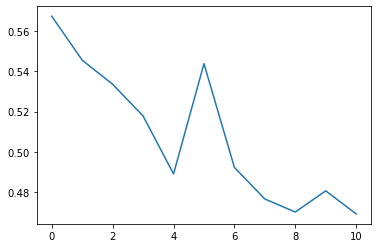

In [98]:
coherence_values = calc_coherence('c_v')
sns.lineplot(data=coherence_values)
plt.show()

In [99]:
# Pick optimal model

# Highest score
opt_ind = np.argmax(coherence_values)

# Manual pick
#opt_ind = 10

optimal_model = lda_model_list[opt_ind]
model_topics = optimal_model.show_topics(formatted=False)
numtopics = optimal_model.num_topics
print('No of topics:',numtopics,' Best score:',max(coherence_values),' No in list:',opt_ind)

No of topics: 10  Best score: 0.5673286680976073  No in list: 0


In [123]:
# Save model
#optimal_model.save('Saved_models/lda_model')

In [124]:
# Load model
optimal_model.load('Saved_models/lda_model')

### Visualize the topics

Basically the bubbles should be as large as people and not overlap. That means the topics are distinct and catch general patterns.

In [103]:
%%capture --no-display
pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.034479 -0.156021       1        1  14.497033
9     -0.053452  0.125974       2        1  13.658964
6      0.031562 -0.083140       3        1  11.706196
5     -0.184061  0.034485       4        1  10.433045
7      0.154432 -0.021222       5        1   9.819698
4     -0.049765  0.185339       6        1   9.614710
8      0.236617 -0.018873       7        1   8.031784
3     -0.224763 -0.033203       8        1   7.621668
0      0.011520 -0.233731       9        1   7.456722
2      0.112389  0.200391      10        1   7.160179, topic_info=          Term      Freq      Total Category  logprob  loglift
21       watch  8.000000   8.000000  Default  30.0000  30.0000
31       phone  6.000000   6.000000  Default  29.0000  29.0000
3    microsoft  7.000000   7.000000  Default  28.0000  28.0000
1       launch  7.000000   7.000000  Default  27.0000  27.0000
999       note  6.000000   6.000000  Default  26.0000  26.0000
..         ...       ...        ...      ...      ...      ...
36        like  2.012323  10.682695  Topic10  -4.6118   0.9673
19        bowl  1.943530  11.606467  Topic10  -4.6465   0.8496
63       built  1.206392   2.966201  Topic10  -5.1234   1.7370
30     network  1.111746   6.796802  Topic10  -5.2051   0.8261
104      deals  1.073617   3.858427  Topic10  -5.2400   1.3574

[509 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
622       7  1.015375             
1065      7  0.999275   accelerate
393       1  0.711600  accessories
393       3  0.355800  accessories
28        1  0.427592     accounts
...     ...       ...          ...
1579      5  0.998767         xbox
11        2  0.171551         year
11        5  0.514652         year
11       10  0.343101         year
1608     10  0.970969         york

[692 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 7, 6, 8, 5, 9, 4, 1, 3])

### Add model to original data

In [105]:
def format_topics(ldamodel, corpus, texts):
    # Init output
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)
    
    return(topics_df)

In [106]:
doc_dominant_df = format_topics(ldamodel=optimal_model, corpus=corpus, texts=news_df['title'])

In [109]:
# Representative Text

topics_sorted = pd.DataFrame()
topics_out_grpd = doc_dominant_df.groupby('Dominant_Topic')

for i, grp in topics_out_grpd:
    topics_sorted = pd.concat([topics_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
# Format
topics_sorted.columns = ["Repr_Dominant_Topic", "Repr_Perc_Contribution", "Repr_Topic_Keywords", "Representative_Text"]

In [110]:
# Join everything
news_analysis_df = pd.concat([news_df,doc_dominant_df],axis='columns')
news_analysis_df = pd.merge(news_analysis_df,topics_sorted,how="inner",left_on='Dominant_Topic',right_on='Repr_Dominant_Topic',sort=True,copy=True)

In [111]:
# Export to csv
news_analysis_df.to_csv('news_analysis.csv',index=False)

### Initial results

**Topics and top words**

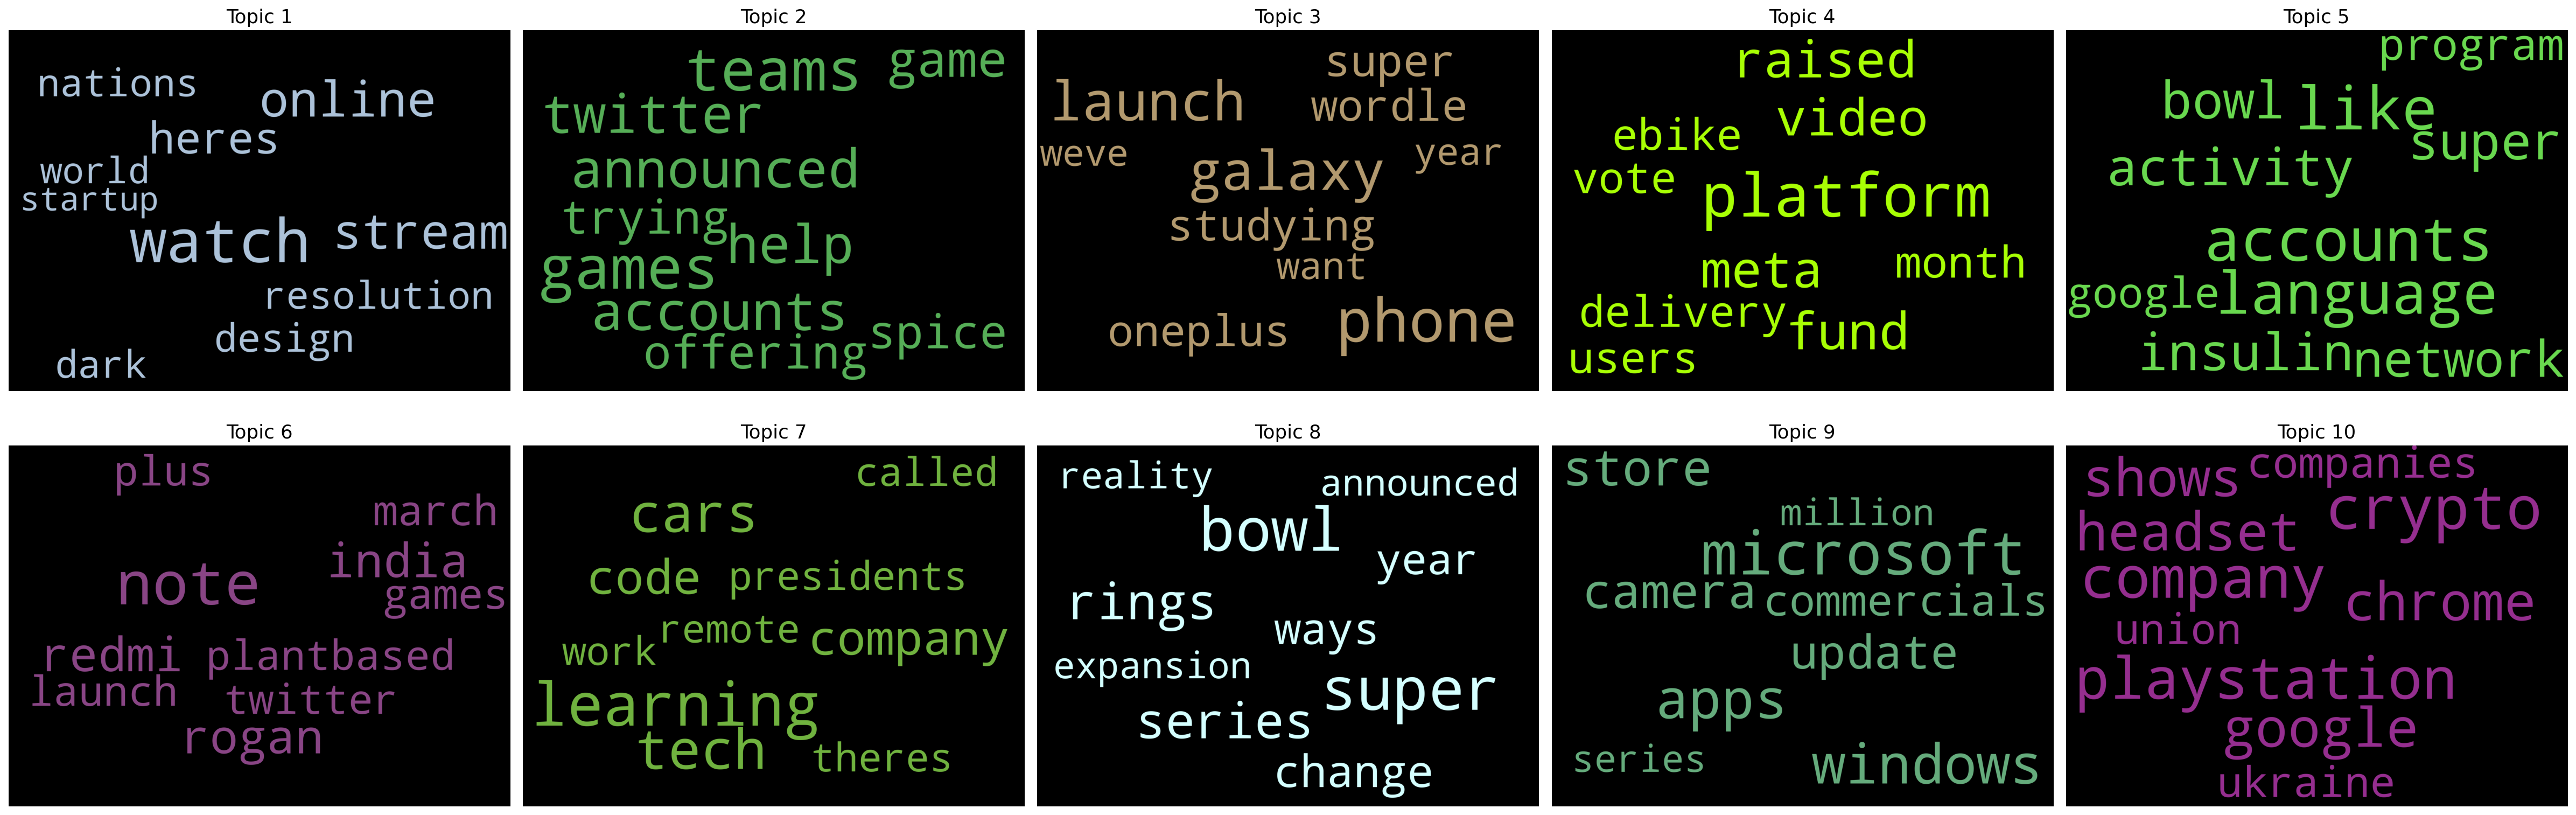

In [122]:
# Wordcloud

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(#stopwords=stop_words,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(num_topics=numtopics, formatted=False, num_words=10)

fig, axes = plt.subplots(2, 5, figsize=(30,10), sharex=True, sharey=True, dpi=160)

for i, ax in enumerate(axes.flatten()):
    if i >= numtopics:
        break
    else:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i+1) + '', fontdict=dict(size=16))
        plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Top-10 words in each topic based on the percentage contribution of the word in the topic

**Topics ranked by coherence**

In [127]:
topic_top_coherence = optimal_model.top_topics(corpus=corpus, texts=texts, dictionary=id2word, window_size=None, coherence='c_v', topn=5, processes=- 1)

In [132]:
pd.DataFrame.from_dict(topic_top_coherence)

,0,1
0,"[(0.03789912, watch), (0.024004368, online), (0.02370499, stream), (0.018864801, heres), (0.01486248, design)]",0.586269
1,"[(0.025526492, microsoft), (0.021018054, windows), (0.021017622, apps), (0.017199097, store), (0.01605993, camera)]",0.570125
2,"[(0.029815285, phone), (0.024297843, galaxy), (0.024155317, launch), (0.0148712685, super), (0.014597983, studying)]",0.382929
3,"[(0.020657586, bowl), (0.020486914, super), (0.013767161, rings), (0.013383159, series), (0.0106957555, change)]",0.372777
4,"[(0.011929905, crypto), (0.011325159, company), (0.011070706, playstation), (0.009710145, google), (0.009349315, headset)]",0.371602
5,"[(0.014005331, learning), (0.011578532, tech), (0.011095274, cars), (0.008707715, company), (0.008652847, code)]",0.354936
6,"[(0.02238681, note), (0.012806077, redmi), (0.012806077, india), (0.012806074, rogan), (0.009864993, games)]",0.351546
7,"[(0.011347469, games), (0.010973461, teams), (0.008890348, accounts), (0.008792674, announced), (0.008754036, help)]",0.236456
8,"[(0.014900113, accounts), (0.014608061, like), (0.01427425, language), (0.010683841, bowl), (0.010665728, super)]",0.194671
9,"[(0.020034341, platform), (0.014010105, fund), (0.0138453655, video), (0.013835604, raised), (0.013810829, meta)]",0.183385


**Topics ranked by number of articles**

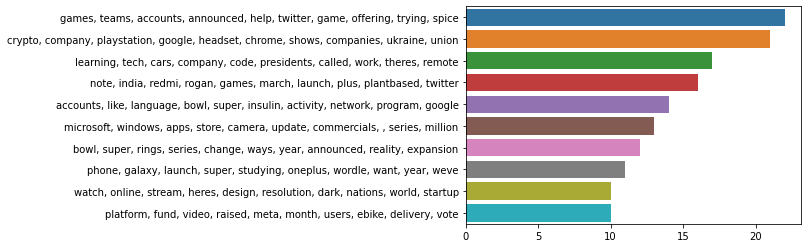

In [113]:
sns.barplot(x=news_analysis_df['Topic_Keywords'].value_counts().values,y=news_analysis_df['Topic_Keywords'].value_counts().index)
plt.show()

**Topics and most representative article**

In [114]:
topics_sorted[['Repr_Topic_Keywords','Representative_Text']]

,Repr_Topic_Keywords,Representative_Text
100,"watch, online, stream, heres, design, resolution, dark, nations, world, startup",How Joe Rogan became the poster child for Spotify’s podcast business
18,"games, teams, accounts, announced, help, twitter, game, offering, trying, spice",European astronauts call for development of a crewed spacecraft
41,"phone, galaxy, launch, super, studying, oneplus, wordle, want, year, weve","Unflow (YC S19) Is Hiring full-stack software engineers (Rails, Remote)"
27,"platform, fund, video, raised, meta, month, users, ebike, delivery, vote",Epson's latest laser projector uses new pixel shift tech to output 4K at 120Hz
31,"accounts, like, language, bowl, super, insulin, activity, network, program, google",Biden administration forms Buy Clean Task Force to decarbonize federal procurement
70,"note, india, redmi, rogan, games, march, launch, plus, plantbased, twitter",Snapchat will let you change your username starting February 23
26,"learning, tech, cars, company, code, presidents, called, work, theres, remote",The Morning After: A 5G necklace for VR and AR
23,"bowl, super, rings, series, change, ways, year, announced, reality, expansion",First 'Dune: Spice Wars' gameplay trailer shows real-time combat
102,"microsoft, windows, apps, store, camera, update, commercials, , series, million",These are the highest-paying design jobs in 2022
30,"crypto, company, playstation, google, headset, chrome, shows, companies, ukraine, union",There are now more than 500 million Epic Games accounts
